In [1]:
pip install torchviz

In [2]:
import torch
import torchvision
import torchvision.datasets
import torchvision.transforms
import torch.utils.data
import torch.nn
import os
from matplotlib import pyplot as plot
import math
from torchviz import make_dot
from IPython.display import display
import time
from torchsummary import summary

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
CLASSES = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
N_CLASSES = len(CLASSES)

def show_images(images, title):
    num_showed_imgs_x = 10
    num_showed_imgs_y = 10

    figsize = (10, 10)
    fig, axes = plot.subplots(num_showed_imgs_y, num_showed_imgs_x, figsize = figsize)
    fig.suptitle(title)
    plot.setp(plot.gcf().get_axes(), xticks = [], yticks = [])
    dataiter = iter(images)
    for i, ax in enumerate(axes.flat):
        img = images[i][0].numpy().transpose(1, 2, 0)
        ax.imshow(img)
        ax.text(1, 1, CLASSES[images[i][1]], bbox=dict(fill=False, edgecolor='red', linewidth=2))

Files already downloaded and verified
Files already downloaded and verified
Number of train samples: 50000
Number of test samples: 10000


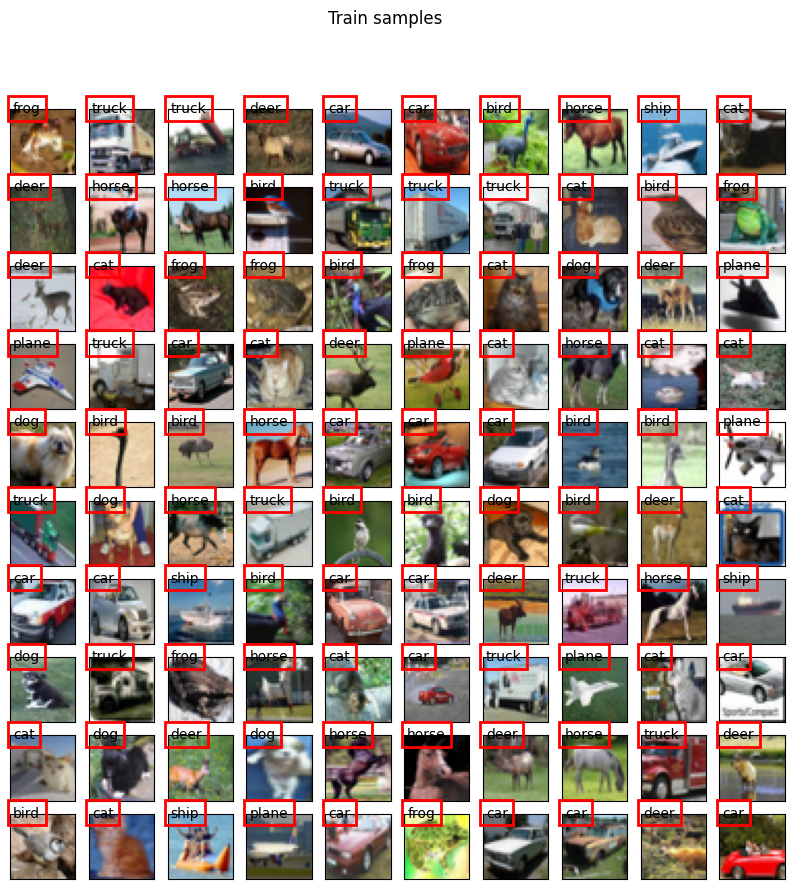

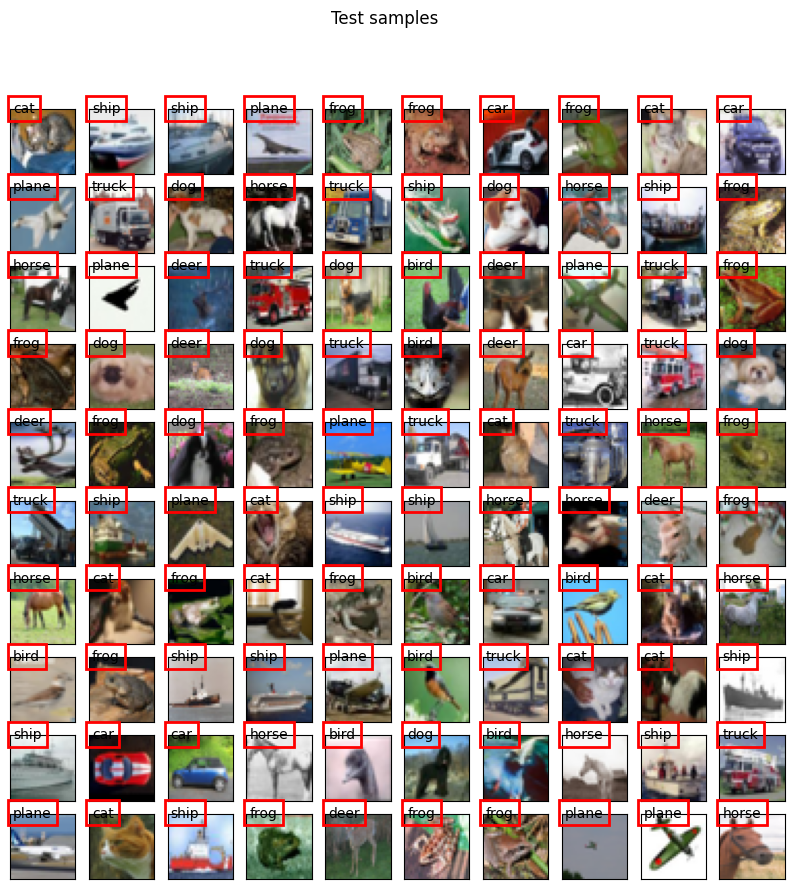

In [5]:
dir_name = os.getcwd()
batch_size = 16

train_dataset = torchvision.datasets.CIFAR10(
    root = dir_name, train = True, download = True,
    transform = torchvision.transforms.ToTensor()
)
test_dataset = torchvision.datasets.CIFAR10(
    root = dir_name, train = False, download = True,
    transform = torchvision.transforms.ToTensor()
)

print('Number of train samples: {}'.format(len(train_dataset)))
show_images(train_dataset, 'Train samples')

print('Number of test samples: {}'.format(len(test_dataset)))
show_images(test_dataset, 'Test samples')

train_data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size = batch_size, shuffle = True
)
test_data_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size = batch_size, shuffle = False
)

In [6]:
train_dataset[6][0].shape

torch.Size([3, 32, 32])

In [7]:
test_dataset[6][0].shape

torch.Size([3, 32, 32])

In [8]:
class ConvBlock(torch.nn.Sequential):
    """
    Standard convolution block with Batch normalization and activation.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 ksize,
                 stride,
                 padding,
                 groups=1,
                 use_bn=True,
                 bn_eps=1e-5,
                 activation=torch.nn.ReLU()):
        super(ConvBlock, self).__init__()
        self.activate = (activation is not None)
        self.use_bn = use_bn

        # with self.init_scope():
        self.conv = torch.nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=ksize,
            stride=stride,
            padding=padding,
            groups=groups)
        if self.use_bn:
            self.bn = torch.nn.BatchNorm2d(out_channels, eps=bn_eps)
        if self.activate:
            self.activ = activation

    def __call__(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.bn(x)
        if self.activate:
            x = self.activ(x)
        return x

In [9]:
def conv1x1_block(in_channels,
                  out_channels,
                  stride=1,
                  padding=0,
                  groups=1,
                  use_bn=True,
                  bn_eps=1e-5,
                  activation=torch.nn.ReLU()):

    return ConvBlock(
        in_channels=in_channels,
        out_channels=out_channels,
        ksize=1,
        stride=stride,
        padding=padding,
        use_bn=use_bn,
        bn_eps=bn_eps,
        activation=activation)

In [10]:
def conv3x3_block(in_channels,
                  out_channels,
                  stride=1,
                  padding=1,
                  groups=1,
                  use_bn=True,
                  bn_eps=1e-5,
                  activation=torch.nn.ReLU()):

    return ConvBlock(
        in_channels=in_channels,
        out_channels=out_channels,
        ksize=3,
        stride=stride,
        padding=padding,
        use_bn=use_bn,
        bn_eps=bn_eps,
        activation=activation)

In [11]:
class SEInitBlock(torch.nn.Module):
    """
    SENet specific initial block.
    """
    def __init__(self,
                 in_channels,
                 out_channels):
        super(SEInitBlock, self).__init__()
        mid_channels = out_channels // 2

        self.conv1 = conv3x3_block(
            in_channels=in_channels,
            out_channels=mid_channels,
            stride=2)
        self.conv2 = conv3x3_block(
            in_channels=mid_channels,
            out_channels=mid_channels)
        self.conv3 = conv3x3_block(
            in_channels=mid_channels,
            out_channels=out_channels)
        self.pool = torch.nn.MaxPool2d(
            kernel_size=3,
            stride=2,
            padding=1)

    def forward(self, x):
        # print("SEInitBlock")
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.pool(x)
        return x

In [12]:
def round_channels(channels,
                   divisor=8):
    """
    Round weighted channel number (make divisible operation).
    """
    rounded_channels = max(int(channels + divisor / 2.0) // divisor * divisor, divisor)
    if float(rounded_channels) < 0.9 * channels:
        rounded_channels += divisor
    return rounded_channels

In [13]:
class SEBlock(torch.nn.Sequential):
    """
    Squeeze-and-Excitation block
    """
    def __init__(self,
                 channels,
                 reduction=16,
                 mid_channels=None,
                 round_mid=False,
                 use_conv=True,
                 mid_activation=torch.nn.ReLU(),
                 out_activation=torch.nn.Sigmoid()):
        super(SEBlock, self).__init__()
        self.use_conv = use_conv
        if mid_channels is None:
            mid_channels = channels // reduction if not round_mid else round_channels(float(channels) / reduction)

        if use_conv:
            self.conv1 = torch.nn.Conv2d(
                in_channels=channels,
                out_channels=mid_channels,
                kernel_size=1,
                bias=True)
        else:
            self.fc1 = torch.nn.Linear(
                in_features=channels,
                out_features=mid_channels)
        self.activ = mid_activation
        if use_conv:
            self.conv2 = torch.nn.Conv2d(
                in_channels=mid_channels,
                out_channels=channels,
                kernel_size=1,
                bias=True)
        else:
            self.fc2 = torch.nn.Linear(
                in_features=mid_channels,
                out_features=channels)
        self.sigmoid = out_activation

    def __call__(self, x):
        # print("SEBlock")
        avgpool = torch.nn.AvgPool2d(kernel_size=x.shape[2:])
        w = avgpool(x)
        if not self.use_conv:
            w = torch.reshape(w, shape=(w.shape[0], -1))
        w = self.conv1(w) if self.use_conv else self.fc1(w)
        w = self.activ(w)
        w = self.conv2(w) if self.use_conv else self.fc2(w)
        w = self.sigmoid(w)
        if not self.use_conv:
            w = torch.unsqueeze(torch.unsqueeze(w, axis=2), axis=3)
        x = x * w
        return x

In [14]:
class SENetBottleneck(torch.nn.Sequential):
    """
    SENet bottleneck block for residual path in SENet unit.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 number_of_groups,
                 bottleneck_width):
        super(SENetBottleneck, self).__init__()
        mid_channels = out_channels // 4
        D = int(math.floor(mid_channels * (bottleneck_width / 64.0)))
        group_width = number_of_groups * D
        group_width2 = group_width // 2

        self.conv1 = conv1x1_block(
            in_channels=in_channels,
            out_channels=group_width2)
        self.conv2 = conv3x3_block(
            in_channels=group_width2,
            out_channels=group_width,
            stride=stride,
            groups=number_of_groups)
        self.conv3 = conv1x1_block(
            in_channels=group_width,
            out_channels=out_channels,
            activation=None)

    def __call__(self, x):
        # print("SENetBottleneck")
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x

In [15]:
class SENetUnit(torch.nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 number_of_groups,
                 bottleneck_width,
                 identity_conv3x3):
        super(SENetUnit, self).__init__()
        self.resize_identity = (in_channels != out_channels) or (stride != 1)

        self.body = SENetBottleneck(
            in_channels=in_channels,
            out_channels=out_channels,
            stride=stride,
            number_of_groups=number_of_groups,
            bottleneck_width=bottleneck_width)
        self.se = SEBlock(channels=out_channels)
        if self.resize_identity:
            if identity_conv3x3:
                self.identity_conv = conv3x3_block(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    stride=stride,
                    activation=None)
            else:
                self.identity_conv = conv1x1_block(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    stride=stride,
                    activation=None)
        self.activ = torch.nn.ReLU()

    def __call__(self, x):
        if self.resize_identity:
            identity = self.identity_conv(x)
        else:
            identity = x
        x = self.body(x)
        x = self.se(x)
        x = x + identity
        x = self.activ(x)
        return x


In [16]:
class MySENet(torch.nn.Module):
    def __init__(self,
                 channels,
                 init_block_channels,
                 number_of_groups,
                 bottleneck_width,
                 in_channels=3,
                 in_size=(32, 32),
                 num_classes=N_CLASSES):
        super(MySENet, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes

        self.features = torch.nn.Sequential()
        self.features.add_module("init_block", SEInitBlock(
            in_channels=in_channels,
            out_channels=init_block_channels))
        in_channels = init_block_channels
        for i, channels_per_stage in enumerate(channels):
            stage = torch.nn.Sequential()
            identity_conv3x3 = (i != 0)
            for j, out_channels in enumerate(channels_per_stage):
                stride = 2 if (j == 0) and (i != 0) else 1
                stage.add_module("unit{}".format(j + 1), SENetUnit(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    stride=stride,
                    number_of_groups=number_of_groups,
                    bottleneck_width=bottleneck_width,
                    identity_conv3x3=identity_conv3x3))
                in_channels = out_channels
            self.features.add_module("stage{}".format(i + 1), stage)
        # self.features.add_module("final_pool", torch.nn.AvgPool2d(
        #     kernel_size=7,
        #     stride=1))
        self.features.add_module("final_pool", torch.nn.AdaptiveAvgPool2d(1))

        self.output = torch.nn.Sequential()
        self.output.add_module("dropout", torch.nn.Dropout(p=0.2))
        self.output.add_module("fc", torch.nn.Linear(
            in_features=in_channels,
            out_features=num_classes))

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, torch.nn.Conv2d):
                torch.nn.init.kaiming_uniform_(module.weight)
                # module.weight = module.weight.to(device)
                if module.bias is not None:
                    # module.bias = module.bias.to(device)
                    torch.nn.init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.output(x)
        return x

In [17]:
def get_senet(blocks,
              model_name=None,
              **kwargs):

    if blocks == 16:
        layers = [1, 1, 1, 1]
        number_of_groups = 32
    elif blocks == 28:
        layers = [2, 2, 2, 2]
        number_of_groups = 32
    elif blocks == 40:
        layers = [3, 3, 3, 3]
        number_of_groups = 32
    else:
        raise ValueError("Unsupported SENet with number of blocks: {}".format(blocks))

    bottleneck_width = 4
    init_block_channels = 128
    channels_per_layers = [256, 512, 1024]

    channels = [[ci] * li for (ci, li) in zip(channels_per_layers, layers)]

    net = MySENet(
        channels=channels,
        init_block_channels=init_block_channels,
        number_of_groups=number_of_groups,
        bottleneck_width=bottleneck_width,
        **kwargs)
    return net


def senet16(**kwargs):
    return get_senet(blocks=16, model_name="senet16")


def senet28(**kwargs):
    return get_senet(blocks=28, model_name="senet28")


def senet40(**kwargs):
    return get_senet(blocks=40, model_name="senet40")

In [18]:
cnn_model=senet16()

In [19]:
def get_accuracy(data_loader, model):
    tp = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            n += labels.size(0)
            tp += (predicted == labels).sum()
    return tp / n

Модель "CNN":
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           1,792
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
              ReLU-4           [-1, 64, 16, 16]               0
              ReLU-5           [-1, 64, 16, 16]               0
              ReLU-6           [-1, 64, 16, 16]               0
              ReLU-7           [-1, 64, 16, 16]               0
              ReLU-8           [-1, 64, 16, 16]               0
            Conv2d-9           [-1, 64, 16, 16]          36,928
      BatchNorm2d-10           [-1, 64, 16, 16]             128
             ReLU-11           [-1, 64, 16, 16]               0
             ReLU-12           [-1, 64, 16, 16]               0
             ReLU-13           [-1, 64, 16, 16]               0
             ReLU-14     

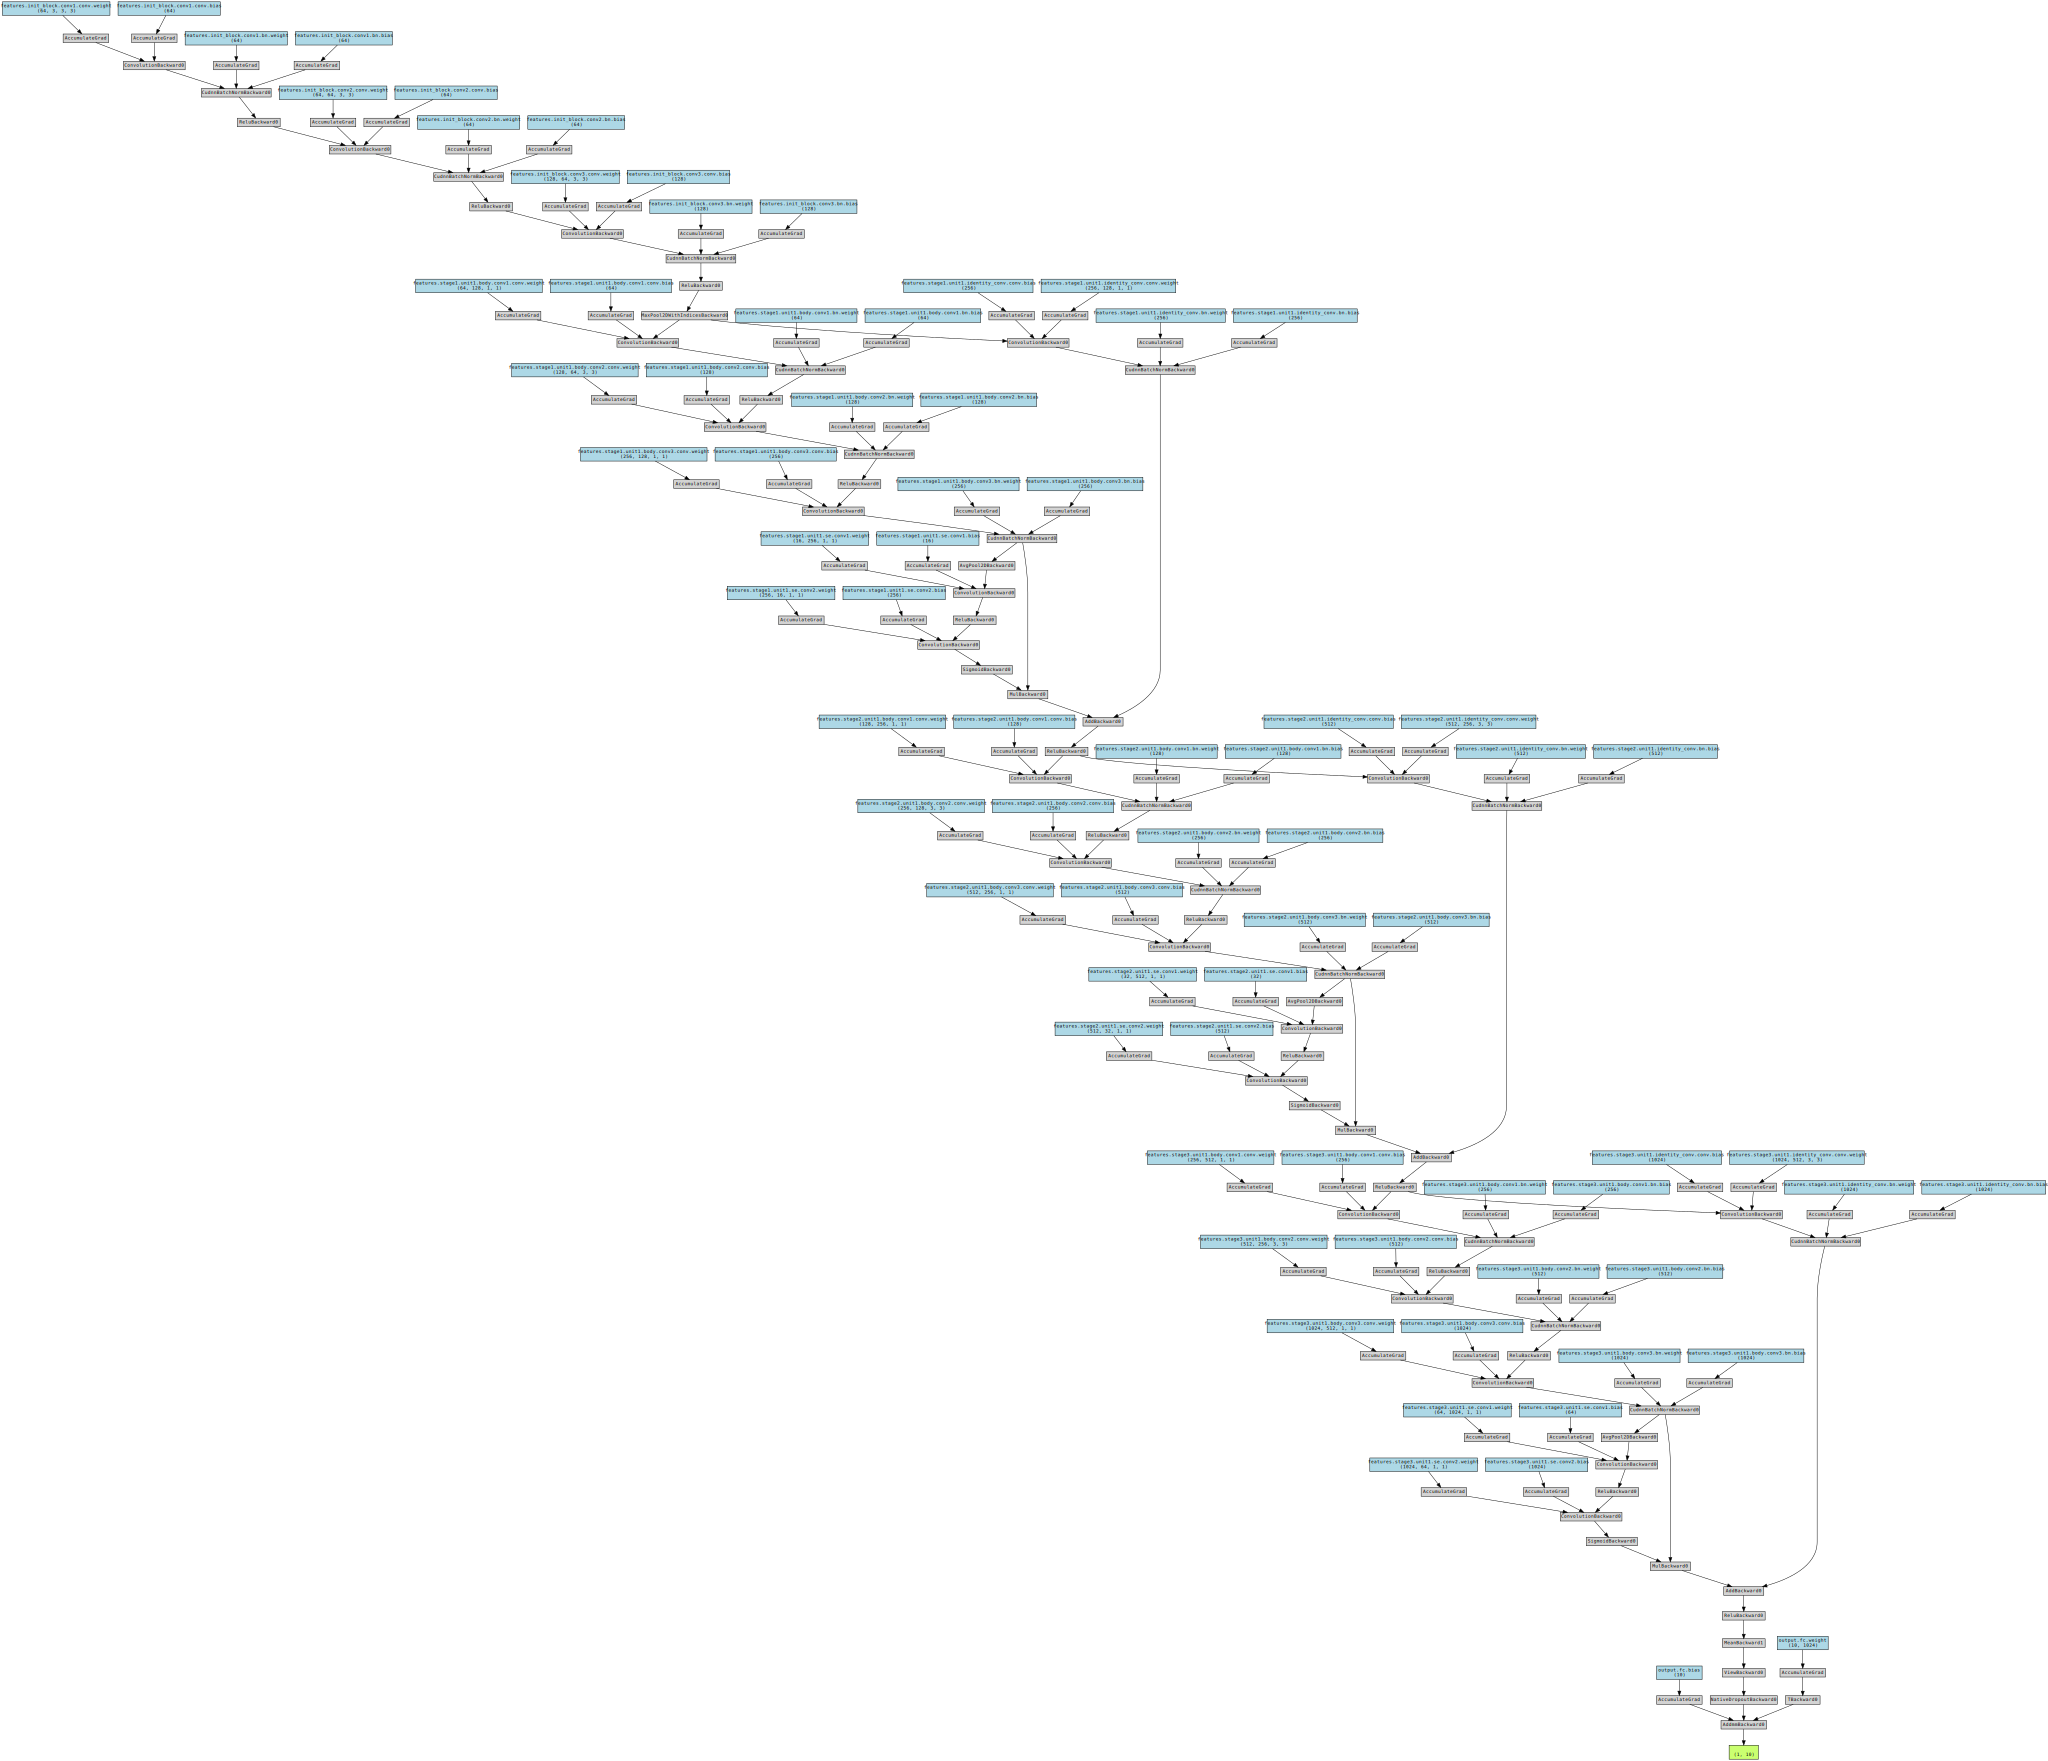

In [20]:
# Информация об архитектуре и визуализация сети
print("Модель \"CNN\":")
summary(cnn_model.to(device), input_size=(3, 32, 32))

print("Визуализация модели:")
display(make_dot(cnn_model(torch.randn(1, 3, 32, 32).to(device)), params=dict(cnn_model.named_parameters())))

In [21]:
learning_rate = 0.1
num_epochs = 20

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn_model.parameters(), lr = learning_rate)

start_all = time.time()
for epoch in range(num_epochs):
    start = time.time()
    for i, (images, labels) in enumerate(train_data_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = cnn_model(images)
        loss = loss_function(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    end = time.time()
    print('Epoch[{}]: accuracy = {}, time = {}'.format(epoch, get_accuracy(train_data_loader, cnn_model), (end - start)))
end_all = time.time()
print('train time = {}'.format((end_all - start_all)))

Epoch[0]: accuracy = 0.6835799813270569, time = 38.34700584411621
Epoch[1]: accuracy = 0.7913399934768677, time = 37.3702495098114
Epoch[2]: accuracy = 0.8375200033187866, time = 37.933491468429565
Epoch[3]: accuracy = 0.8983599543571472, time = 37.171271324157715
Epoch[4]: accuracy = 0.9249799847602844, time = 37.8235969543457
Epoch[5]: accuracy = 0.9432799816131592, time = 37.87195301055908
Epoch[6]: accuracy = 0.9565399885177612, time = 37.62522339820862
Epoch[7]: accuracy = 0.9709799885749817, time = 37.49402189254761
Epoch[8]: accuracy = 0.9698799848556519, time = 37.93991184234619
Epoch[9]: accuracy = 0.9809999465942383, time = 37.350093603134155
Epoch[10]: accuracy = 0.9861199855804443, time = 37.438411235809326
Epoch[11]: accuracy = 0.9856599569320679, time = 37.6477108001709
Epoch[12]: accuracy = 0.9884600043296814, time = 37.56942677497864
Epoch[13]: accuracy = 0.9910999536514282, time = 37.77301216125488
Epoch[14]: accuracy = 0.9917399883270264, time = 37.387455463409424
Epo

In [22]:
print('Test accuracy: {}'.format(get_accuracy(test_data_loader, cnn_model)))

Test accuracy: 0.7863999605178833


In [26]:
%%shell
jupyter nbconvert --to html /content/Prac1_DL.ipynb

[NbConvertApp] WARNING | pattern '/content/Prac1_DL.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execu

CalledProcessError: ignored

In [ ]:
pip install ray

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 MB 10.4 MB/s eta 0:00:00


In [ ]:
import ray
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from functools import partial
from filelock import FileLock
from ray import train, tune
from ray.train import Checkpoint

In [ ]:
def train_cifar(config):
  learning_rate = config["learning_rate"]
  batch_size = config["batch_size"]
  num_epochs = 5
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


  dir_name = os.getcwd()

  train_dataset = torchvision.datasets.CIFAR10(
      root = dir_name, train = True, download = True,
      transform = torchvision.transforms.ToTensor()
  )
  test_dataset = torchvision.datasets.CIFAR10(
      root = dir_name, train = False, download = True,
      transform = torchvision.transforms.ToTensor()
  )

  # print('Number of train samples: {}'.format(len(train_dataset)))
  # show_images(train_dataset, 'Train samples')

  # print('Number of test samples: {}'.format(len(test_dataset)))
  # show_images(test_dataset, 'Test samples')

  train_data_loader = torch.utils.data.DataLoader(
      train_dataset, batch_size = batch_size, shuffle = True
  )
  test_data_loader = torch.utils.data.DataLoader(
      test_dataset, batch_size = batch_size, shuffle = False
  )

  cnn_model=senet16()

  cnn_model.to(device)
  loss_function = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(cnn_model.parameters(), lr = learning_rate)

  start_all = time.time()
  for epoch in range(num_epochs):
      start = time.time()
      for i, (images, labels) in enumerate(train_data_loader):
          images = images.to(device)
          labels = labels.to(device)

          outputs = cnn_model(images)
          loss = loss_function(outputs, labels)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
      end = time.time()
      accuracy = get_accuracy(train_data_loader, cnn_model)
      print('Epoch[{}]: accuracy = {}, time = {}'.format(epoch, accuracy, (end - start)))
  end_all = time.time()
  print('train time = {}'.format((end_all - start_all)))

  os.makedirs("my_model", exist_ok=True)
  torch.save(
      (cnn_model.state_dict(), optimizer.state_dict()), "my_model/checkpoint.pt")
  checkpoint = Checkpoint.from_directory("my_model")
  train.report({"accuracy": accuracy.item()}, checkpoint=checkpoint)

In [ ]:
config = {
      "learning_rate": tune.choice([1e-3, 1e-1]),
      "batch_size": tune.choice([4, 8, 16, 32])
  }
max_num_epochs = 10
num_samples = 10

scheduler = ASHAScheduler(
        # metric="loss",
        # mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)

tuner = tune.Tuner(
    tune.with_resources(
        tune.with_parameters(train_cifar),
        # resources={"cpu": 2, "gpu": 0}
        resources={"cpu": 2, "gpu": 1}
    ),
    tune_config=tune.TuneConfig(
        metric="accuracy",
        mode="min",
        scheduler=scheduler,
        num_samples=num_samples,
    ),
    param_space=config,
)
results = tuner.fit()

best_result = results.get_best_result("accuracy", "min", "last")
print("Best trial config: {}".format(best_result .config))
print("Best trial final validation accuracy: {}".format(
    best_result .last_result["accuracy"]))
print("Best trial final validation accuracy: {}".format(
    best_result .last_result["accuracy"]))
# best_trained_model = cnn_model(best_trial.config["l1"], best_trial.config["l2"])

# best_trained_model.to(device)
# print('Test accuracy: {}'.format(get_accuracy(test_data_loader, best_trained_model)))

NameError: ignored